In [2]:
# Importing packages we may need in this assignment 
import networkx as nx
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

### Assets Prices Analysis:
a. To create the correlation matrix, I simply use Pandas to read the csv data file and clean the columns names to make it easier to read the asset name. Then, I calculate the log of daily returns and use the corr() function to calculate the cross correlation. Finally, I print out the correlation matrix.

In [3]:
data = pd.read_csv('asset_prices.csv', index_col='Date')
assetscodes = []
for c in data.columns:
    if len(c) > 6:
        data.rename(columns = {c:c[4:7]}, inplace = True)
        assetscodes.append(c[4:7])
lreturns = pd.DataFrame()
for col in data.columns:
    lreturns[col] = np.log(data[col]).diff(-1)
#returnscorrmatrix = lreturns.corr()
corrmatrix = lreturns.corr()
print(corrmatrix)

          BND       DBC       DIA       EEM       EFA       EMB       EPP  \
BND  1.000000 -0.086234 -0.279161 -0.069623 -0.177521  0.296679 -0.104739   
DBC -0.086234  1.000000  0.305137  0.428909  0.369637  0.313791  0.400316   
DIA -0.279161  0.305137  1.000000  0.719260  0.793387  0.343817  0.688344   
EEM -0.069623  0.428909  0.719260  1.000000  0.796425  0.580454  0.815049   
EFA -0.177521  0.369637  0.793387  0.796425  1.000000  0.466883  0.790699   
EMB  0.296679  0.313791  0.343817  0.580454  0.466883  1.000000  0.481680   
EPP -0.104739  0.400316  0.688344  0.815049  0.790699  0.481680  1.000000   
EWG -0.188547  0.283711  0.722882  0.697222  0.884385  0.394289  0.650267   
EWI -0.201014  0.331083  0.666315  0.660268  0.830052  0.349381  0.611764   
EWJ -0.159231  0.250509  0.691672  0.638955  0.785198  0.359046  0.624245   
EWQ -0.174957  0.322063  0.729587  0.721991  0.913501  0.416390  0.669246   
EWU -0.176372  0.410183  0.746862  0.749025  0.905149  0.436164  0.732445   

b. Simple Graph: We can produce a simple graph from the Correlation Matrix above. Then, I remove the self loops as they don't give any insight. In order to display the graph in a nice circular layout, I used the function circular_layout() to define the positions of the nodes. Finally, I draw the graph using draw() and add the asset codes as labels of the nodes.

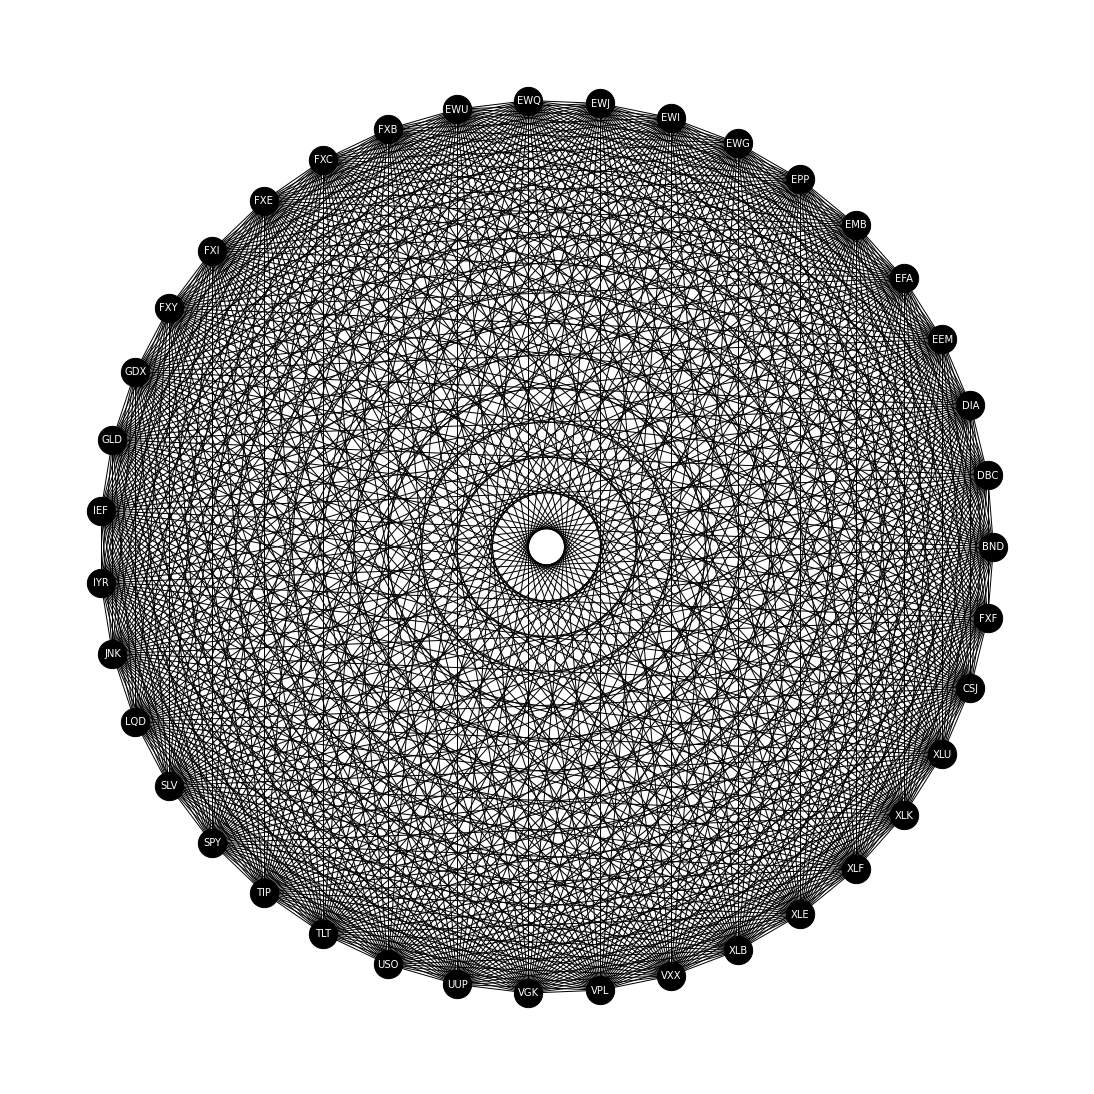

In [4]:
edges = corrmatrix.stack().reset_index()
edges.columns = ["a", "b", "correlation"]
assets = nx.from_pandas_edgelist(edges, "a", "b", edge_attr=["correlation"])
assets.remove_edges_from(nx.selfloop_edges(assets))
plt.figure(figsize=(15,15))
pos=nx.circular_layout(assets)
nx.draw(assets, pos, node_color='black',node_size=800, with_labels=True, font_size=10, font_color='white')

Although we only have 39 nodes here, it is impossible to draw any insight from this graph due to the following reasons:

  1. This is a complete undirected graph which means we have 780 edges including the self-loops which makes it too busy, and
  2. Although the underlining graph is weighted, we have nothing that represents the weight yet in the visualization.

In the next iteration, I address the problem by:

  1. set direction and strength of correlation as attributes to the edges, and 
  2. map the direction and strength of correlation to edge color (Tableau blue for positive correclation, Tableau orange for negative correlation, and none for zero correlation) and edge alpha respectively
  
Tableau Blue and Orange are improve the readability of the visualization for color-blind people. The mapping of the correlation to categories of correlation strength is following the Conventional Approach to Interpreting a Correlation Coefficient mention on <a href="https://journals.lww.com/anesthesia-analgesia/fulltext/2018/05000/correlation_coefficients__appropriate_use_and.50.aspx">Correlation Coefficients: Appropriate Use and Interpretationt</a>. From now on, I use the terminology outlined in this reference for referring to the strength of correlation.  

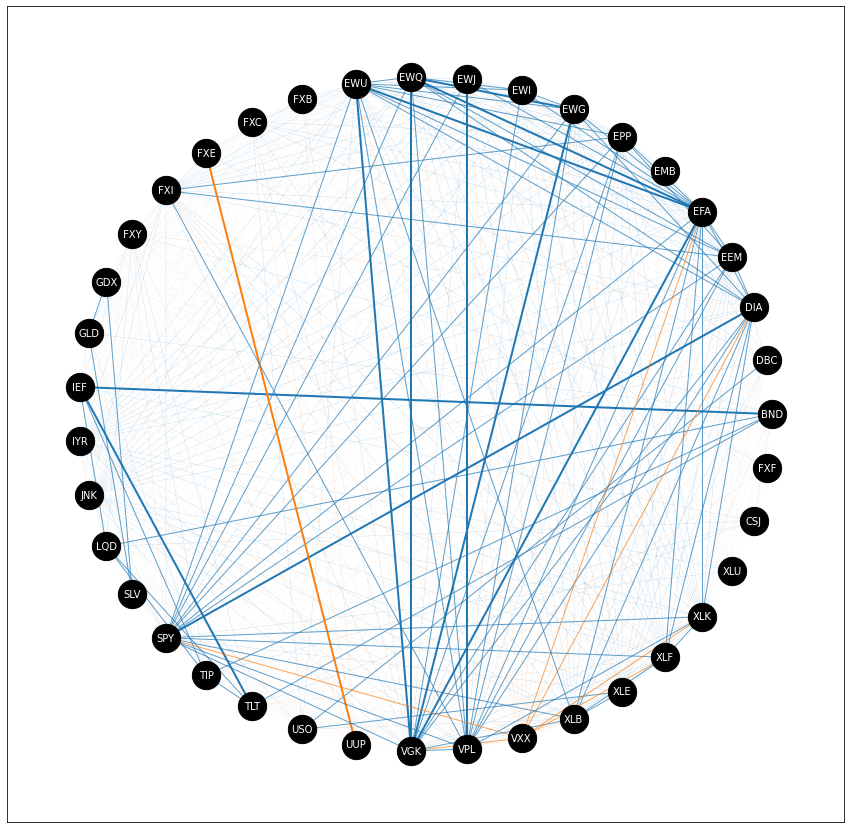

In [5]:
directions = dict()
strengths = dict()
edgescolors = dict()
edgesalphas = dict()
edgeswidths = dict()

nx.set_edge_attributes(assets, directions, "direction")
nx.set_edge_attributes(assets, strengths, "strength")
nx.set_edge_attributes(assets, edgescolors, "color")
nx.set_edge_attributes(assets, edgesalphas, "alpha")
nx.set_edge_attributes(assets, edgeswidths, "width")

for s , d in assets.edges():
    if assets[s][d]['correlation'] > 0:
        assets[s][d]['direction'] = 'positive'
        assets[s][d]['color'] = 'tab:blue' 
    elif assets[s][d]['correlation'] < 0:
        assets[s][d]['direction'] = 'negative'
        assets[s][d]['color'] = 'tab:orange'
    else:
        assets[s][d]['direction'] = 'none'
        assets[s][d]['color'] = 'tab:grey'

directions = nx.get_edge_attributes(assets,'direction')
edgecolors = nx.get_edge_attributes(assets,'color')

direction = list(directions[d] for d in directions)
edgecolor = list(edgecolors[c] for c in edgecolors)

for s , d in assets.edges():
    if abs(assets[s][d]['correlation']) <= 0.1:
        assets[s][d]['strength'] = 'negligible'
        assets[s][d]['alpha'] = 0
        assets[s][d]['width'] = 0.1
    elif abs(assets[s][d]['correlation']) < 0.4:
        assets[s][d]['strength'] = 'weak'
        assets[s][d]['alpha'] = 0.1
        assets[s][d]['width'] = 0.2
    elif abs(assets[s][d]['correlation']) < 0.7:
        assets[s][d]['strength'] = 'moderate'
        assets[s][d]['alpha'] = 0.3
        assets[s][d]['width'] = 0.3
    elif abs(assets[s][d]['correlation']) < 0.9:
        assets[s][d]['strength'] = 'strong'
        assets[s][d]['alpha'] = 0.7
        assets[s][d]['width'] = 1
    else:
        assets[s][d]['strength'] = 'very strong'
        assets[s][d]['alpha'] = 1
        assets[s][d]['width'] = 2

strengths = nx.get_edge_attributes(assets,'strength')
edgealphas = nx.get_edge_attributes(assets,'alpha')    
edgeswidths = nx.get_edge_attributes(assets,'width')

strength = list(strengths[s] for s in strengths)
edgealpha = list(edgealphas[a] for a in edgealphas)
edgewidth = list(edgeswidths[a] for a in edgeswidths)

plt.figure(figsize=(15,15))
pos=nx.circular_layout(assets)
nx.draw_networkx_nodes(assets, pos, node_color='black',node_size=800)
nx.draw_networkx_labels(assets, pos, font_size=10, font_color='white')
nx.draw_networkx_edges(assets, pos, edge_color = edgecolor, alpha = edgealpha, width= edgewidth)

From this graph we observe some assets (e.g., SPY, VGK, VPL) with stronger correlation than others and some assets tend to have more negative correlations than positive ones (e.g., VXX and UUP). We also observe some nodes that only have only weak correlations (e.g., FXY). These are already alot of features of the assets from which we can draw a lot of useful insights to make investment decisions. In the following iteration, I remove the edges representing negligible and weak correlations which helps making the graph more sparse and more interesting to further analyze.

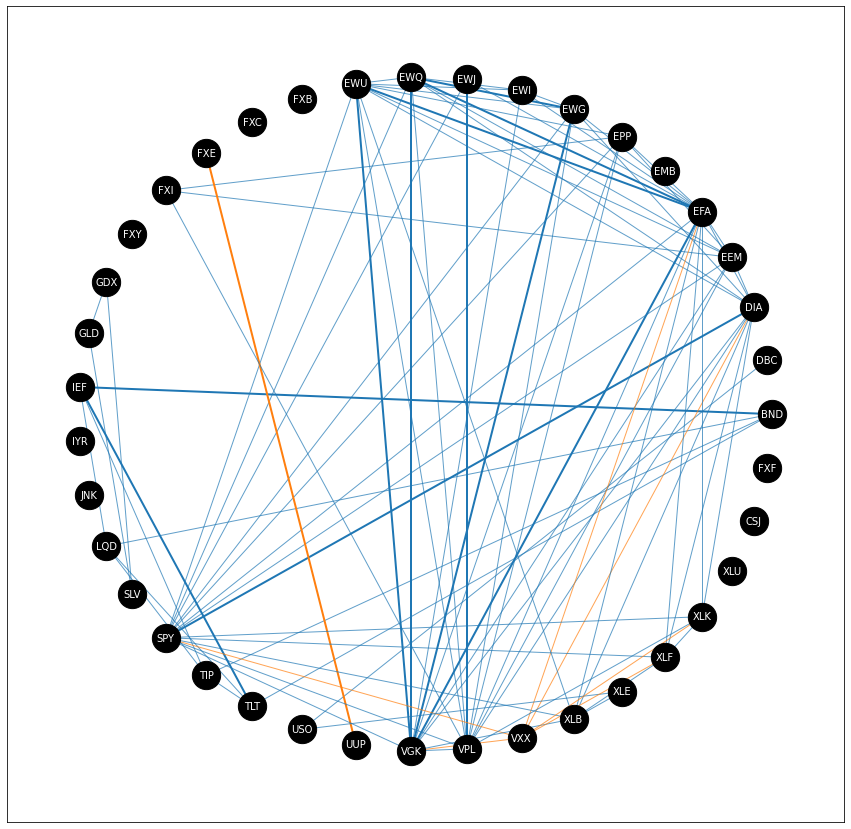

In [6]:
removededges = []
for a,b in assets.edges():
    if abs(assets[a][b]["correlation"]) < 0.7:
        removededges.append((a, b))

assets.remove_edges_from(removededges)
strength.clear()
edgealpha.clear()
direction.clear()
edgecolor.clear()
edgewidth.clear()

strength = list(nx.get_edge_attributes(assets,'strength').values())
edgealpha = list(nx.get_edge_attributes(assets,'alpha').values())
direction = list(nx.get_edge_attributes(assets,'direction').values())
edgecolor = list(nx.get_edge_attributes(assets,'color').values())
edgewidth = list(nx.get_edge_attributes(assets,'width').values())

plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(assets, pos, node_color='black',node_size=800)
nx.draw_networkx_labels(assets, pos, font_size=10, font_color='white')
nx.draw_networkx_edges(assets, pos, edge_color = edgecolor, alpha = edgealpha, width= edgewidth)

Now, we can observe the isolated nodes (assets) which don't have any significant correlation with other assets in our graph. In the following iteration, I go for setting the node size based on its degree centrality in the graph to signify the importance of each node in the graph.

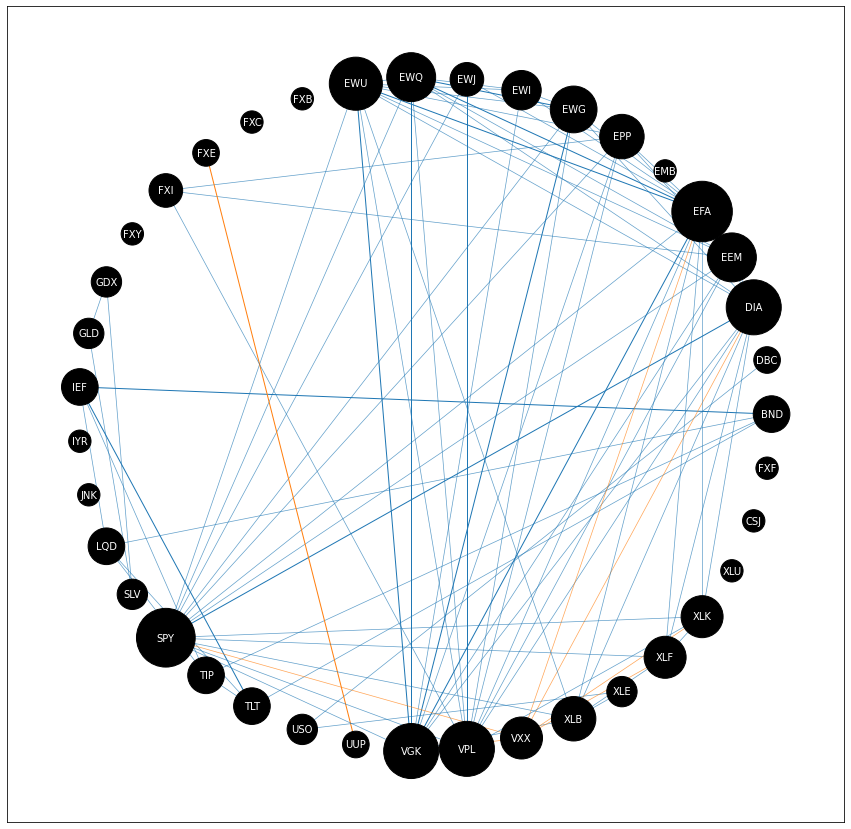

In [7]:
nodesize = []
for n in nx.degree_centrality(assets).values():
    nodesize.append(500+8000*n)
pos=nx.circular_layout(assets)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(assets, pos, node_color='black',node_size=nodesize)
nx.draw_networkx_labels(assets, pos, font_size=10, font_color='white')
nx.draw_networkx_edges(assets, pos, edge_color = edgecolor, alpha = edgealpha, width= edgealpha)

In real life, the returns of the assets are essential in making investment decisions. In the following iteration, I use the blue color of the nodes to indicate an asset that made profit during the period of the analysis and orange color to indicate an asset that made losses during the same period. The alpha of the node color will indicate the magnitude of the profit and loss so light blue will indicate relatively small profits while dark blue will indicate relatively strong performance.  

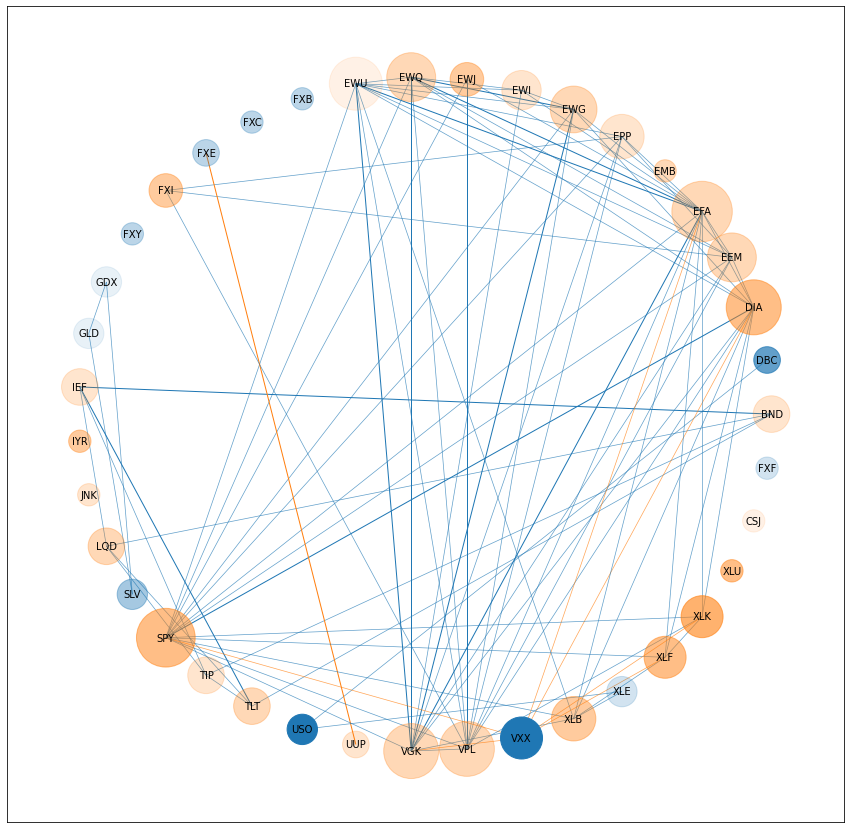

In [8]:
totalreturnsdict = dict()
profitloss = dict()
nodescolors = list()
nodesalphas = list()

for col in lreturns.columns:
    totalreturnsdict[col]=(data[col][1012]/data[col][0]-1)
    nodealpha = min(round(abs(data[col][1012]/data[col][0]-1),1)+0.1,1)
    if (data[col][1012]/data[col][0]-1) > 0:
        profitloss[col]='profit'
        nodescolors.append('tab:blue')
        nodesalphas.append(nodealpha)
    else:
        profitloss[col]='loss'
        nodescolors.append('tab:orange')
        nodesalphas.append(nodealpha)
        
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(assets, pos, node_color=nodescolors,node_size=nodesize, alpha=nodesalphas)
nx.draw_networkx_labels(assets, pos, font_size=10, font_color='black')
nx.draw_networkx_edges(assets, pos, edge_color = edgecolor, alpha = edgealpha, width= edgealpha)

I experimented with various layout options available from Networkx and still find the circular one the most readable. I also experimented with excluding isolated nodes which turns out to be a bad idea in this context because these assets / asset classes could be useful to design a portfolio that suits a particular investor. 

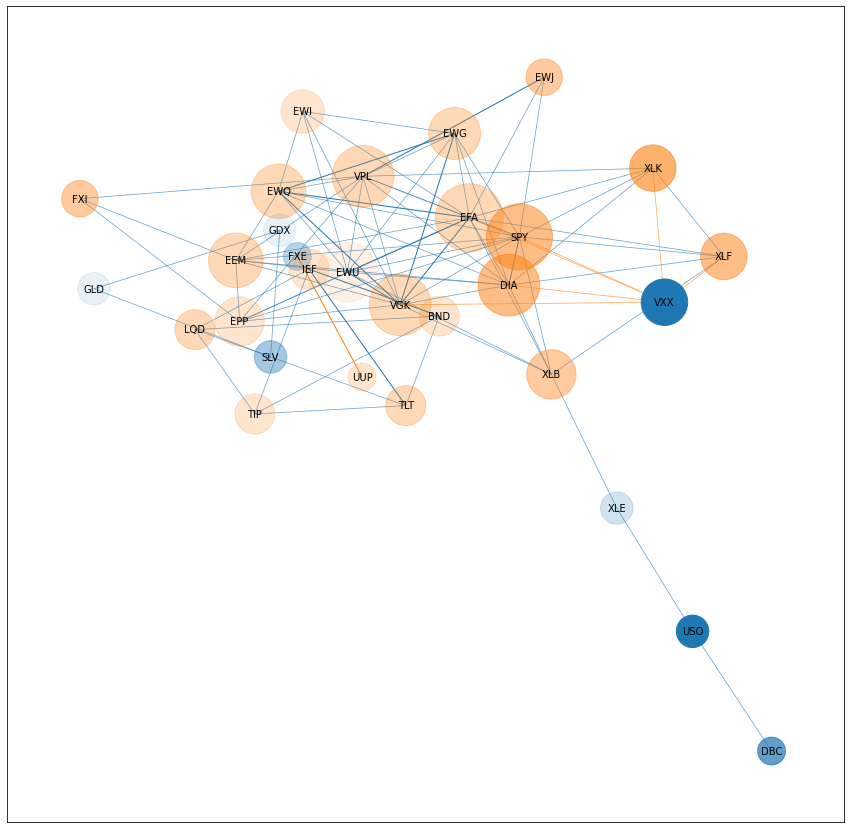

In [9]:
assets.remove_nodes_from(list(nx.isolates(assets)))
strength.clear()
edgealpha.clear()
direction.clear()
edgecolor.clear()
edgewidth.clear()

strength = list(nx.get_edge_attributes(assets,'strength').values())
edgealpha = list(nx.get_edge_attributes(assets,'alpha').values())
direction = list(nx.get_edge_attributes(assets,'direction').values())
edgecolor = list(nx.get_edge_attributes(assets,'color').values())
edgewidth = list(nx.get_edge_attributes(assets,'width').values())

nodesize = []
for n in nx.degree_centrality(assets).values():
    nodesize.append(500+8000*n)

totalreturnsdict.clear()
profitloss.clear()
nodescolors.clear()
nodesalphas.clear()

for n in list(assets.nodes()):
    totalreturnsdict[n]=(data[n][1012]/data[n][0]-1)
    nodealpha = min(round(abs(data[n][1012]/data[n][0]-1),1)+0.1,1)
    if (data[n][1012]/data[n][0]-1) > 0:
        profitloss[n]='profit'
        nodescolors.append('tab:blue')
        nodesalphas.append(nodealpha)
    else:
        profitloss[n]='loss'
        nodescolors.append('tab:orange')
        nodesalphas.append(nodealpha)

finalpos=nx.kamada_kawai_layout(assets)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(assets, finalpos, node_color=nodescolors,node_size=nodesize, alpha=nodesalphas)
nx.draw_networkx_labels(assets, finalpos, font_size=10, font_color='black')
nx.draw_networkx_edges(assets, finalpos, edge_color = edgecolor, alpha = edgealpha, width= edgealpha)